# Import necessary libraries

In [1]:
import torch
import os
import wget
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetRegressor
from pathlib import Path

from scipy import stats
from scipy.special import inv_boxcox

np.random.seed(0)
sb.set() 
model = TabNetRegressor(device_name='cuda') 


/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [2]:
final_data= pd.read_csv('data/clean_data/final_data.csv')

with open('data/clean_data/encoding_mappings.json', 'r') as fp:
    encoding_mappings = json.load(fp)


In [3]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

In [4]:
features = ['Year','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']
target = 'resale_price_adjusted'

# Employing basic linearing regression model with the numerical data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(final_data[features], final_data[target], test_size=0.1, random_state=42)



In [12]:
#for linreg
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


y_train_boxcox, lambda_boxcox = stats.boxcox(y_train)
y_test_boxcox = stats.boxcox(y_test, lmbda=lambda_boxcox) 

#Tabnet
X_train_tabnet, X_valid_tabnet, y_train_tabnet, y_valid_tabnet = train_test_split(X_train, y_train, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

X_train_tabnet_values = X_train_tabnet.values
X_valid_tabnet_values = X_valid_tabnet.values

#log transformation
y_train_tabnet_log_values = np.log(y_train_tabnet.values).reshape(-1, 1)
y_valid_tabnet_log_values = np.log(y_valid_tabnet.values).reshape(-1, 1)

#boxcox transformation
y_train_tabnet_box, lambda_boxcox_tabnet = stats.boxcox(y_train_tabnet.values)
y_test_tabnet_box = stats.boxcox(y_valid_tabnet.values,lmbda=lambda_boxcox_tabnet)

y_train_tabnet_box_values = y_train_tabnet_box.reshape(-1,1)
y_train_tabnet_box_values = y_test_tabnet_box.reshape(-1,1)

In [13]:
# Train a linear regression no Transformation
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Train a XGBoost model no Transformation
xgbreg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg.fit(X_train,y_train)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Train a linear regression model after log transformation
linreg_withLog = LinearRegression()
linreg_withLog.fit(X_train, y_train_log)

# Train a XGBoost model after log transformation
xgbreg_withLog = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg_withLog.fit(X_train,y_train_log)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Train a linear regression model after boxcox transformation
linreg_withBoxCox = LinearRegression()
linreg_withLog.fit(X_train, y_train_boxcox)

# Train a XGBoost model after boxcox transformation
xgbreg_withBoxCox = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg_withLog.fit(X_train,y_train_boxcox)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
# Train a tabnet model after log ransformation
tabnetReg_log = TabNetRegressor()
max_epochs = 200

tabnetReg_log.fit(
    X_train_tabnet_values, 
    y_train_tabnet_log_values,
    eval_set=[(X_train_tabnet_values, y_train_tabnet_log_values), 
              (X_valid_tabnet_values, y_valid_tabnet_log_values)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','rmse'],
    max_epochs = 200,
    patience = 10,
    batch_size = 8192,
    virtual_batch_size = 1024,
    num_workers = 0,
    drop_last=False
)

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 15.44543| train_mae: 18.83681| train_rmse: 39.22885| valid_mae: 19.10064| valid_rmse: 39.6433 |  0:00:08s
epoch 1  | loss: 0.05235 | train_mae: 3.97237 | train_rmse: 7.03578 | valid_mae: 3.90796 | valid_rmse: 6.87121 |  0:00:16s
epoch 2  | loss: 0.04158 | train_mae: 5.08446 | train_rmse: 8.4846  | valid_mae: 5.11936 | valid_rmse: 8.51954 |  0:00:25s
epoch 3  | loss: 0.03586 | train_mae: 2.18898 | train_rmse: 3.66274 | valid_mae: 2.19618 | valid_rmse: 3.67018 |  0:00:33s
epoch 4  | loss: 0.03422 | train_mae: 1.44193 | train_rmse: 2.14711 | valid_mae: 1.4447  | valid_rmse: 2.14732 |  0:00:41s
epoch 5  | loss: 0.0305  | train_mae: 0.82271 | train_rmse: 1.02901 | valid_mae: 0.82294 | valid_rmse: 1.02914 |  0:00:49s
epoch 6  | loss: 0.02794 | train_mae: 0.41748 | train_rmse: 0.4908  | valid_mae: 0.41777 | valid_rmse: 0.49075 |  0:00:58s
epoch 7  | loss: 0.02732 | train_mae: 0.26166 | train_rmse: 0.30993 | valid_mae: 0.26146 | valid_rmse: 0.30989 |  0:01:06s
epoch 8  | loss:

KeyboardInterrupt: 

In [ ]:
# Train a tabnet model after boxcox ransformation
tabnetReg_box = TabNetRegressor()
max_epochs = 200

tabnetReg_box.fit(
    X_train_tabnet_values, 
    y_train_tabnet_log_values,
    eval_set=[(X_train_tabnet_values, y_train_tabnet_log_values), 
              (X_valid_tabnet_values, y_valid_tabnet_log_values)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','rmse'],
    max_epochs = 200,
    patience = 10,
    batch_size = 4096,
    virtual_batch_size = 512,
    num_workers = 0,
    drop_last=False
)

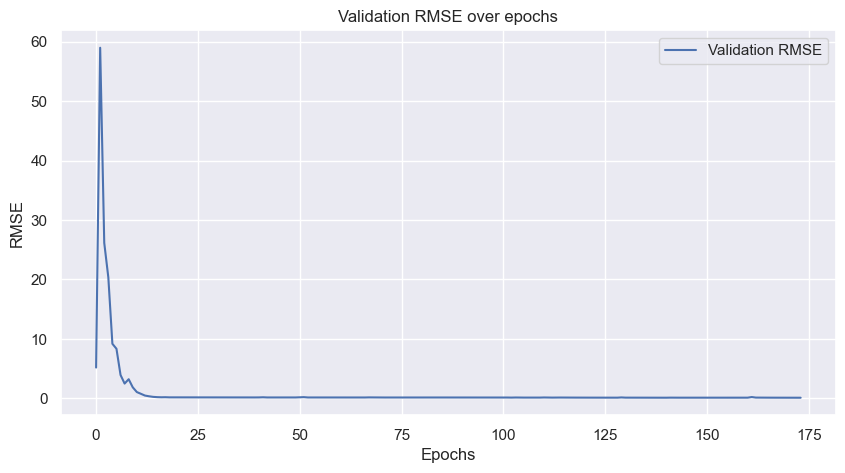

In [84]:
valid_rmse_log = tabnetReg_log.history['valid_rmse']

epochs = range(len(valid_rmse_log))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse_log, label='Validation RMSE')
plt.title('Validation RMSE Over Epochs for Log Transformation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
valid_rmse_box = tabnetReg_box.history['valid_rmse']

epochs = range(len(valid_rmse_box))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse_box, label='Validation RMSE')
plt.title('Validation RMSE Over Epochs for BoxCox Transformation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [82]:
#default
linear_regression_coefficients = linreg.coef_
linear_regression_intercept = linreg.intercept_
xgboost_feature_importances = xgbreg.feature_importances_

#log
linear_regression_withlog_coefficients = linreg_withLog.coef_
linear_regression_withlog_intercept = linreg_withLog.intercept_
xgboost_withLog_feature_importances = xgbreg_withLog.feature_importances_
tabnetlog_feature_importances = tabnetReg_log.feature_importances_

#boxcox
linear_regression_withbox_coefficients = linreg_withBoxCox.coef_
linear_regression_withbox_intercept = linreg_withBoxCox.intercept_
xgboost_withBox_feature_importances = xgbreg_withBoxCox.feature_importances_
tabnetbox_feature_importances = tabnetReg_box.feature_importances_

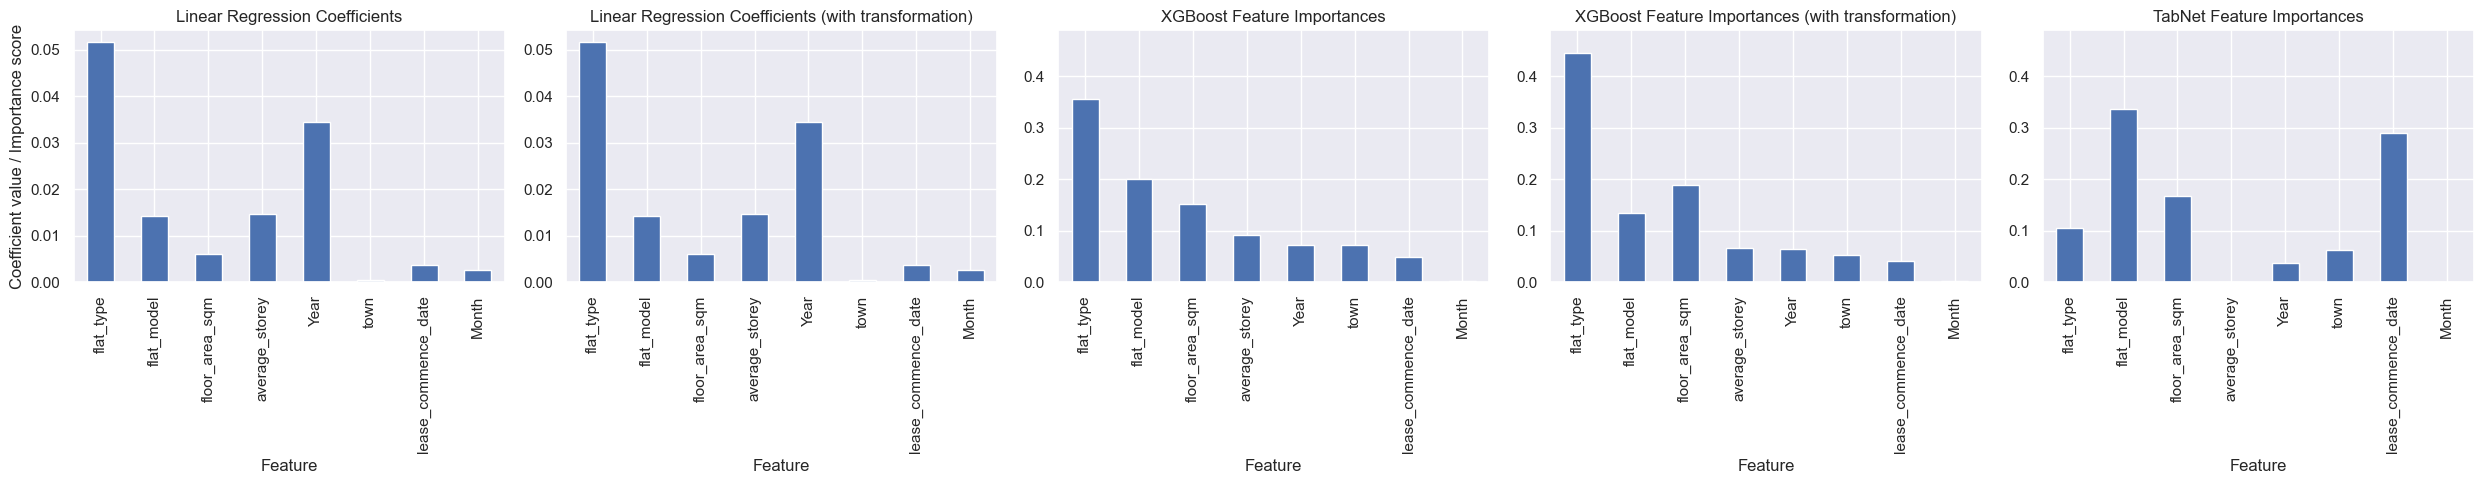

In [83]:
# Create a DataFrame to hold the feature importances
df_feature_importance = pd.DataFrame({
    'Feature': features,
    'Linear Regression': linear_regression_coefficients,
    'Linear Regression (with log transformation)': linear_regression_withlog_coefficients,
    'Linear Regression (with boxcox transformation)': linear_regression_withbox_coefficients,
    'XGBoost': xgboost_feature_importances,
    'XGBoost (with log transformation)': xgboost_withLog_feature_importances,
    'XGBoost (with boxcox transformation)': xgboost_withBox_feature_importances,
    'TabNet (with log transformation)': tabnetlog_feature_importances,
    'TabNet (with log transformation)': tabnetbox_feature_importances
})

df_feature_importance.sort_values(by='XGBoost', ascending=False, inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 5))
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression', ax=axes[0], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression (with log transformation)', ax=axes[1], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression (with box transformation)', ax=axes[2], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost', ax=axes[3], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost (with log transformation)', ax=axes[4], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost (with box transformation)', ax=axes[5], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='TabNet (with log transformation)', ax=axes[6], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='TabNet (with box transformation)', ax=axes[7], legend=False)

axes[0].set_title('Linear Regression Coefficients')
axes[1].set_title('Linear Regression Coefficients (with log transformation)')
axes[2].set_title('Linear Regression Coefficients (with boxcox transformation)')
axes[3].set_title('XGBoost Feature Importances')
axes[4].set_title('XGBoost Feature Importances (with log transformation)')
axes[5].set_title('XGBoost Feature Importances (with boxcox transformation)')
axes[6].set_title('TabNet Log Transformation Feature Importances')
axes[7].set_title('TabNet BoxCox TransformationFeature Importances')

axes[0].set_ylabel('Coefficient value / Importance score')

# Find the global maximum importance for XGBoost and TabNet
xgb_max = max(max(xgboost_feature_importances), max(xgboost_withLog_feature_importances),max(xgboost_withBox_feature_importances))
tabnet_max = max(max(tabnetlog_feature_importances),max(tabnetbox_feature_importances))
common_max = max(xgb_max, tabnet_max)

# Set the same y-axis limits for the XGBoost and TabNet plots
for ax in axes[2:]:
    ax.set_ylim(0, common_max + 0.1 * common_max)

plt.tight_layout()
plt.show()

In [ ]:
from joblib import dump,load

#no transformation
dump(linreg, '.models/linreg/linreg.joblib')
xgbreg.save_model('./models/xgb/xgb_linreg.json')

#log transformation
dump(linreg_withLog, './models/linreg/linreg_log.joblib')
xgbreg_withLog.save_model('./models/xgb/xgb_linreg_log.json')
tabnetReg_log.save_model('./models/tabnet/tabnet_log')

#boxcox transformation

dump(linreg_withBoxCox, './models/linreg/linreg_boxcox.joblib')
xgbreg_withBoxCox.save_model('./models/xgb/xgb_linreg_box.json')
tabnetReg_box.save_model('./models/tabnet/tabnet_boxcox')

